# A look at solution data and processed variables

Once you have run a simulation the first thing you want to do is have a look at the data. Most of the examples so far have made use of PyBaMM's handy QuickPlot function but there are other ways to access the data and this notebook will explore them. First off we will generate a standard SPMe model and use QuickPlot to view the default variables.

In [1]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

# load model
model = pybamm.lithium_ion.SPMe()

# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = model.default_parameter_values
param.process_model(model)
param.process_geometry(geometry)

# set mesh
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# solve model
solver = model.default_solver
dt = 1e-3
t_eval = np.arange(0, 0.15, dt)
solution = solver.solve(model, t_eval)

quick_plot = pybamm.QuickPlot(solution)

import ipywidgets as widgets
widgets.interact(quick_plot.plot, t=widgets.FloatSlider(min=0,max=quick_plot.max_t,step=0.05,value=0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9353313389920834, step=0.05), Output()), _…

Behind the scenes the QuickPlot classed has created some processed variables which can interpolate the model variables for our solution and has also stored the results for the solution steps

In [2]:
solution.data.keys()

dict_keys(['Negative particle surface concentration', 'Electrolyte concentration', 'Positive particle surface concentration', 'Current [A]', 'Negative electrode potential [V]', 'Electrolyte potential [V]', 'Positive electrode potential [V]', 'Terminal voltage [V]'])

In [3]:
solution.data['Negative particle surface concentration'].shape

(20, 150)

In [4]:
solution.t.shape

(150,)

Notice that the dictionary keys are in the same order as the subplots in the QuickPlot figure. We can add new processed variables to the solution by simply using it like a dictionary. First lets find a few more variables to look at. As you will see there are quite a few:

In [5]:
keys = list(model.variables.keys())
keys.sort()
print(keys)

['Active material volume fraction', 'Battery voltage [V]', 'C-rate', 'Cell temperature', 'Cell temperature [K]', 'Current [A]', 'Current collector current density', 'Current collector current density [A.m-2]', 'Discharge capacity [A.h]', 'Electrode current density', 'Electrode tortuosity', 'Electrolyte concentration', 'Electrolyte concentration [Molar]', 'Electrolyte concentration [mol.m-3]', 'Electrolyte current density', 'Electrolyte current density [A.m-2]', 'Electrolyte flux', 'Electrolyte flux [mol.m-2.s-1]', 'Electrolyte potential', 'Electrolyte potential [V]', 'Electrolyte pressure', 'Electrolyte tortuosity', 'Exchange current density', 'Exchange current density [A.m-2]', 'Exchange current density per volume [A.m-3]', 'Gradient of electrolyte potential', 'Gradient of negative electrode potential', 'Gradient of negative electrolyte potential', 'Gradient of positive electrode potential', 'Gradient of positive electrolyte potential', 'Gradient of separator electrolyte potential', '

In [6]:
solution['Time [h]']

This created a new processed variable and stored it on the solution object

In [7]:
solution.data.keys()

dict_keys(['Negative particle surface concentration', 'Electrolyte concentration', 'Positive particle surface concentration', 'Current [A]', 'Negative electrode potential [V]', 'Electrolyte potential [V]', 'Positive electrode potential [V]', 'Terminal voltage [V]', 'Time [h]'])

We can see the actual data in one of two ways, first by simply accessing the entries attribute of the processed variable

In [8]:
solution['Time [h]'].entries

array([0.        , 0.00627739, 0.01255478, 0.01883217, 0.02510957,
       0.03138696, 0.03766435, 0.04394174, 0.05021913, 0.05649652,
       0.06277392, 0.06905131, 0.0753287 , 0.08160609, 0.08788348,
       0.09416087, 0.10043826, 0.10671566, 0.11299305, 0.11927044,
       0.12554783, 0.13182522, 0.13810261, 0.14438001, 0.1506574 ,
       0.15693479, 0.16321218, 0.16948957, 0.17576696, 0.18204435,
       0.18832175, 0.19459914, 0.20087653, 0.20715392, 0.21343131,
       0.2197087 , 0.2259861 , 0.23226349, 0.23854088, 0.24481827,
       0.25109566, 0.25737305, 0.26365044, 0.26992784, 0.27620523,
       0.28248262, 0.28876001, 0.2950374 , 0.30131479, 0.30759219,
       0.31386958, 0.32014697, 0.32642436, 0.33270175, 0.33897914,
       0.34525653, 0.35153393, 0.35781132, 0.36408871, 0.3703661 ,
       0.37664349, 0.38292088, 0.38919828, 0.39547567, 0.40175306,
       0.40803045, 0.41430784, 0.42058523, 0.42686262, 0.43314002,
       0.43941741, 0.4456948 , 0.45197219, 0.45824958, 0.46452

Secondly by calling the method with a specific solution time, which is non-dimensional

In [9]:
solution.t

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
       0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
       0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125,
       0.126, 0.127,

In [10]:
solution['Time [h]'](solution.t)

array([0.        , 0.00627739, 0.01255478, 0.01883217, 0.02510957,
       0.03138696, 0.03766435, 0.04394174, 0.05021913, 0.05649652,
       0.06277392, 0.06905131, 0.0753287 , 0.08160609, 0.08788348,
       0.09416087, 0.10043826, 0.10671566, 0.11299305, 0.11927044,
       0.12554783, 0.13182522, 0.13810261, 0.14438001, 0.1506574 ,
       0.15693479, 0.16321218, 0.16948957, 0.17576696, 0.18204435,
       0.18832175, 0.19459914, 0.20087653, 0.20715392, 0.21343131,
       0.2197087 , 0.2259861 , 0.23226349, 0.23854088, 0.24481827,
       0.25109566, 0.25737305, 0.26365044, 0.26992784, 0.27620523,
       0.28248262, 0.28876001, 0.2950374 , 0.30131479, 0.30759219,
       0.31386958, 0.32014697, 0.32642436, 0.33270175, 0.33897914,
       0.34525653, 0.35153393, 0.35781132, 0.36408871, 0.3703661 ,
       0.37664349, 0.38292088, 0.38919828, 0.39547567, 0.40175306,
       0.40803045, 0.41430784, 0.42058523, 0.42686262, 0.43314002,
       0.43941741, 0.4456948 , 0.45197219, 0.45824958, 0.46452

And interpolated

In [11]:
interp_t = (solution.t[0] + solution.t[1])/2
solution['Time [h]'](interp_t)

array(0.0031387)

In [12]:
var = 'X-averaged negative electrode temperature [K]'
solution[var](interp_t)

array(298.15)

This solution was created in one go with the solver's solve method but it is also possible to step the solution and look at the results as we go. However, care must be taken when doing this as the processed variables also need to be updated.

In [13]:
dt = 0.05
time = 0
end_time = solution.t[-1]
step_solver = model.default_solver
step_solution = None
while time < end_time:
    current_step_sol = step_solver.step(model, dt=dt, npts=10)
    if not step_solution:
        # create solution object on first step
        step_solution = current_step_sol
    else:
        # append solution from the current step to step_solution
        step_solution.append(current_step_sol)
    print('Time', time)
    print(step_solution["Terminal voltage [V]"].entries)
    time += dt

Time 0
[3.77057107 3.73890422 3.72440875 3.71142961 3.69977291 3.68944471
 3.68038153 3.67246541 3.66553752 3.65937842]
Time 0.05
[3.77057107 3.73890422 3.72440875 3.71142961 3.69977291 3.68944471
 3.68038153 3.67246541 3.66553752 3.65937842]
Time 0.1
[3.77057107 3.73890422 3.72440875 3.71142961 3.69977291 3.68944471
 3.68038153 3.67246541 3.66553752 3.65937842]


Here we see our solution entries are not changing

2020-01-15 09:38:43,654 - [WARNING] processed_variable.__call__(322): Calling variable outside interpolation range (returns 'nan')


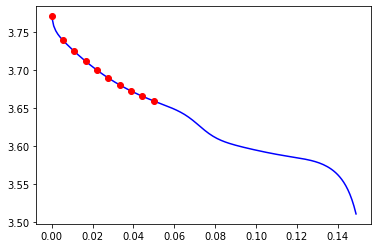

In [14]:
voltage = solution["Terminal voltage [V]"]
step_voltage = step_solution["Terminal voltage [V]"]
plt.figure()
plt.plot(solution.t, voltage(solution.t), "b-", label="SPMe (continuous solve)")
plt.plot(
    step_solution.t, step_voltage(step_solution.t), "ro", label="SPMe (stepped solve)"
)

In [15]:
time = 0
end_time = solution.t[-1]
step_solver = model.default_solver
step_solution = None
while time < end_time:
    current_step_sol = step_solver.step(model, dt=dt, npts=10)
    if not step_solution:
        # create solution object on first step
        step_solution = current_step_sol
    else:
        # append solution from the current step to step_solution
        step_solution.append(current_step_sol)
    step_solution.update("Terminal voltage [V]")
    print('Time', time)
    print(step_solution["Terminal voltage [V]"].entries)
    time += dt

Time 0
[3.77057107 3.73890422 3.72440875 3.71142961 3.69977291 3.68944471
 3.68038153 3.67246541 3.66553752 3.65937842]
Time 0.05
[3.77057107 3.73890422 3.72440875 3.71142961 3.69977291 3.68944471
 3.68038153 3.67246541 3.66553752 3.65937842 3.65360157 3.64734181
 3.63884614 3.62696324 3.61519642 3.60725969 3.60218779 3.59830099
 3.59486892]
Time 0.1
[3.77057107 3.73890422 3.72440875 3.71142961 3.69977291 3.68944471
 3.68038153 3.67246541 3.66553752 3.65937842 3.65360157 3.64734181
 3.63884614 3.62696324 3.61519642 3.60725969 3.60218779 3.59830099
 3.59486892 3.59172124 3.5888885  3.5863745  3.58391715 3.58074722
 3.57544446 3.56563286 3.54593129 3.4990516 ]


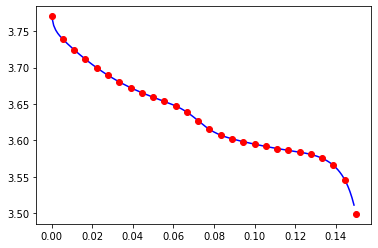

In [16]:
voltage = solution["Terminal voltage [V]"]
step_voltage = step_solution["Terminal voltage [V]"]
plt.figure()
plt.plot(solution.t, voltage(solution.t), "b-", label="SPMe (continuous solve)")
plt.plot(
    step_solution.t, step_voltage(step_solution.t), "ro", label="SPMe (stepped solve)"
)